In [1]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import shap
import numpy as np


patient_details = pd.read_csv('heart_attack_prediction_dataset.csv')
patient_details_drop = ['Patient ID', 'Hemisphere', 'Continent', 'Country','Obesity','Exercise Hours Per Week','Previous Heart Problems', 'Medication Use','Sleep Hours Per Day','Income', 'Sedentary Hours Per Day','Physical Activity Days Per Week','Heart Attack Risk','Heart Rate']
pdet = patient_details.drop(columns=patient_details_drop, inplace=True)
patent = patient_details.iloc[:4920]
patent

ModuleNotFoundError: No module named 'pandas'

In [14]:
disease_symptoms = pd.read_csv('Training.csv')

# Drop the 'Gender' and 'Age' columns from disease_symptoms

disease_symptoms.drop(columns=['Unnamed: 133'], inplace=True)
# Join necessary columns from patient_details to disease_symptoms
columns_to_add = [
    'Age', 'Sex','Diabetes', 'Family History', 'Smoking',
    'Alcohol Consumption', 'Diet', 'Stress Level', 'BMI', 'Triglycerides','Cholesterol','Blood Pressure'
]

# Ensure that the DataFrames have the same length before joining
if len(patent) == len(disease_symptoms):
    disease_symptoms[columns_to_add] = patient_details[columns_to_add]
else:
    print("dataframe!")

# Display the updated DataFrame
disease_symptoms


,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,Diabetes,Family History,Smoking,Alcohol Consumption,Diet,Stress Level,BMI,Triglycerides,Cholesterol,Blood Pressure
0,1,1,1,0,0,0,0,0,0,0,...,0,0,1,0,Average,9,31.251233,286,208,158/88
1,0,1,1,0,0,0,0,0,0,0,...,1,1,1,1,Unhealthy,1,27.194973,235,389,165/93
2,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,Healthy,9,28.176571,587,324,174/99
3,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,Average,9,36.464704,378,383,163/100
4,1,1,1,0,0,0,0,0,0,0,...,1,1,1,0,Unhealthy,6,21.809144,231,318,91/88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,Healthy,5,35.883516,466,275,126/62
4916,0,1,0,0,0,0,0,0,0,0,...,1,1,1,1,Healthy,8,22.606108,532,228,179/89
4917,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,Unhealthy,1,28.999388,166,133,116/77
4918,0,1,0,0,0,0,1,0,0,0,...,1,1,1,0,Unhealthy,6,33.814342,423,247,98/103


In [15]:
#pre-processing
df = pd.DataFrame(disease_symptoms)
df.dropna(inplace=True)
# df.columns.tolist()
# features_to_scale = [ 'Stress Level', 'BMI', 'Triglycerides','Cholesterol', 'Blood Pressure']

In [16]:
def categorize_blood_pressure(bp):
    systolic, diastolic = map(int, bp.split('/'))
    if systolic < 100 or diastolic < 70:
        return 'Low'
    elif 90 <= systolic <= 120 and 60 <= diastolic <= 80:
        return 'Normal'
    else:
        return 'High'

In [17]:
# Check if 'Blood Pressure' column exists
if 'Blood Pressure' in df.columns:
    # Split the "Blood Pressure" column
    df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)

    # Convert new columns to numeric
    df['Systolic_BP'] = pd.to_numeric(df['Systolic_BP'], errors='coerce')
    df['Diastolic_BP'] = pd.to_numeric(df['Diastolic_BP'], errors='coerce')

    # Drop the original "Blood Pressure" column
    df.drop('Blood Pressure', axis=1, inplace=True)

    # Fill any NaN values if necessary, e.g., with mean or median of the column
    df['Systolic_BP'].fillna(df['Systolic_BP'].mean(), inplace=True)
    df['Diastolic_BP'].fillna(df['Diastolic_BP'].mean(), inplace=True)


In [18]:
# Convert categorical columns to numeric using LabelEncoder
labelencoder = LabelEncoder()
df['Sex'] = labelencoder.fit_transform(df['Sex'])
df['Diet'] = labelencoder.fit_transform(df['Diet'])
df['prognosis'] = labelencoder.fit_transform(df['prognosis'])

# Check the data types to ensure all are numeric
print("Data types of the DataFrame columns:")
print(df.dtypes)


Data types of the DataFrame columns:
itching                   int64
skin_rash                 int64
nodal_skin_eruptions      int64
continuous_sneezing       int64
shivering                 int64
                         ...   
BMI                     float64
Triglycerides             int64
Cholesterol               int64
Systolic_BP               int64
Diastolic_BP              int64
Length: 146, dtype: object


In [19]:
# Separate features and target variable
X = df.drop('prognosis', axis=1)
y = df['prognosis']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Univariate Feature Selection
bestfeatures = SelectKBest(score_func=f_classif, k=20)
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print("Univariate Selection Scores:\n", featureScores)


Univariate Selection Scores:
                   Feature        Score
0                 itching  1415.960266
1               skin_rash  1249.943435
2    nodal_skin_eruptions   863.374349
3     continuous_sneezing  1039.241318
4               shivering  1045.000000
..                    ...          ...
140                   BMI     1.410023
141         Triglycerides     1.222403
142           Cholesterol     1.045778
143           Systolic_BP     0.955728
144          Diastolic_BP     0.874545

[145 rows x 2 columns]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 45  77 108 120] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [21]:
# Recursive Feature Elimination (RFE)
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=20)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 20
Selected Features: [ True  True False False False  True  True False False False False  True
 False False  True False False False False False False  True False False
  True  True False False  True False False  True  True False  True  True
 False False False  True  True False False False False False False False
 False False False False False False False False  True False False False
 False False False False  True False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
Feature Ranking: [  1   1  40  16  52   1   1  11  36  77  75   1   5  69   1 11

Feature Importances from RandomForest:
 muscle_pain       0.017533
chest_pain        0.014750
unsteadiness      0.014590
itching           0.014537
high_fever        0.014498
                    ...   
Sex               0.000583
Diabetes          0.000523
Family History    0.000518
Smoking           0.000496
fluid_overload    0.000000
Length: 145, dtype: float64


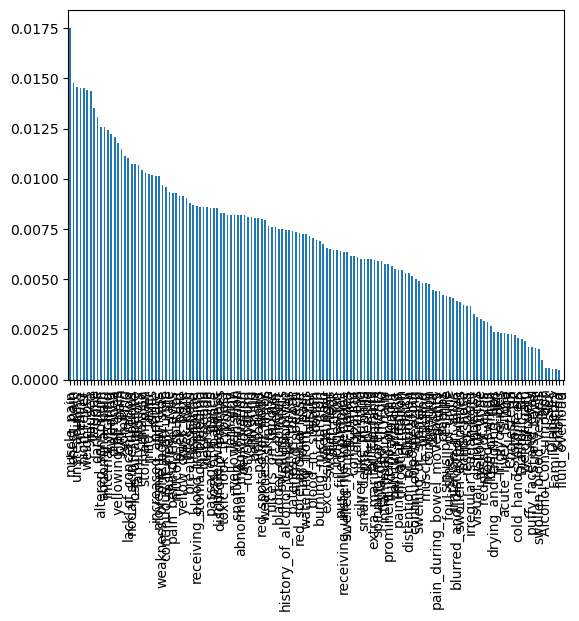

In [22]:
# Tree-based Feature Importance using Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("Feature Importances from RandomForest:\n", feature_importances)
feature_importances.plot(kind='bar')
plt.show()


In [23]:
# Evaluate model accuracy using the selected features from RFE
selected_features = X_train[:, fit.support_]

In [24]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'SVM': SVC()
}

In [25]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVM': {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1]}
}


In [26]:
# Function to perform model evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    return accuracy, precision, recall, f1

In [27]:
# Evaluate and tune each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(selected_features, y_train)
    best_model = grid_search.best_estimator_
    accuracy, precision, recall, f1 = evaluate_model(best_model, X_test[:, fit.support_], y_test)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")


Evaluating Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for Logistic Regression: {'C': 1}
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-score: 0.88

Evaluating Decision Tree
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-score: 0.88

Evaluating Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
Accuracy: 0.90
Precision: 0.89
Recall: 0.90
F1-score: 0.88

Evaluating Gradient Boosting
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'n_estimators': 200}
Accuracy: 0.89
Precision: 0.88
Recall: 0.89
F1-score: 0.88

Evaluating AdaBoost
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 200}
Accuracy: 0.87
Precision: 0.86
Recall: 0.88
F1-score: 0.86

Evaluating SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM: {'C': 1, 'gamma': 0.1}
Accuracy: 0.89
Precision: 0.88
Recall: 0.89
F1-score: 0.88


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Ensemble Method: Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000, C=0.1)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)),
    ('svc', SVC(C=10, gamma=0.01, probability=True))
], voting='soft')

voting_clf.fit(selected_features, y_train)
accuracy, precision, recall, f1 = evaluate_model(voting_clf, X_test[:, fit.support_], y_test)
print("\nEnsemble Model (Voting Classifier) Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Ensemble Model (Voting Classifier) Evaluation:
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-score: 0.88


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# Output detailed classification report for the best model (Random Forest in this case)
best_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
best_rf.fit(selected_features, y_train)
y_pred_rf = best_rf.predict(X_test[:, fit.support_])
print("\nDetailed Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Evaluate model accuracy using the selected features from RFE
selected_features = X_train[:, fit.support_]
model = LogisticRegression(max_iter=1000)
model.fit(selected_features, y_train)
scores = cross_val_score(model, X_test[:, fit.support_], y_test, cv=5)
print("Model accuracy with selected features: %.2f%%" % (scores.mean() * 100))

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.88      0.93      0.90        30
           2       0.73      0.92      0.81        24
           3       1.00      0.96      0.98        25
           4       1.00      0.88      0.93        24
           5       0.26      1.00      0.41        23
           6       1.00      1.00      1.00        33
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        23
          11       1.00      1.00      1.00        26
          12       0.95      1.00      0.98        21
          13       0.00      0.00      0.00        29
          14       0.50      0.04      0.08        24
          15       0.41      0.79      0.54        19
          16       1.00      1

Data types of the DataFrame columns:
itching                   int64
skin_rash                 int64
nodal_skin_eruptions      int64
continuous_sneezing       int64
shivering                 int64
                         ...   
BMI                     float64
Triglycerides             int64
Cholesterol               int64
Systolic_BP               int64
Diastolic_BP              int64
Length: 146, dtype: object

Evaluating Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [45] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for Logistic Regression: {'C': 0.01}
Validation Accuracy: 0.28
Validation Precision: 0.24
Validation Recall: 0.27
Validation F1-score: 0.25
Validation ROC-AUC: 0.72

Evaluating Decision Tree
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}
Validation Accuracy: 0.28
Validation Precision: 0.24
Validation Recall: 0.27
Validation F1-score: 0.25
Validation ROC-AUC: 0.72

Evaluating Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
Validation Accuracy: 0.28
Validation Precision: 0.24
Validation Recall: 0.27
Validation F1-score: 0.25
Validation ROC-AUC: 0.72

Evaluating Gradient Boosting
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'n_estimators': 50}
Validation Accuracy: 0.28
Validation Precision: 0.24
Validation Recall: 0.27
Validation F1-score: 0.25
Validation ROC-AUC: 0.72

Evaluating AdaBoost
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 50}
Validation Accuracy: 0.26
Validation Precision: 0.21
Validation Recall: 0.24
Validation F1-score: 0.21
Validation ROC-AUC: 0.72

Evaluating SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters for SVM: {'C': 0.1, 'gamma': 0.01}
Validation Accuracy: 0.28
Validation Precision: 0.24
Validation Recall: 0.27
Validation F1-score: 0.25
Validation ROC-AUC: 0.72


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: Undefi


Best Model: Logistic Regression
Test Accuracy: 0.28
Test Precision: 0.24
Test Recall: 0.27
Test F1-score: 0.25
Test ROC-AUC: 0.72


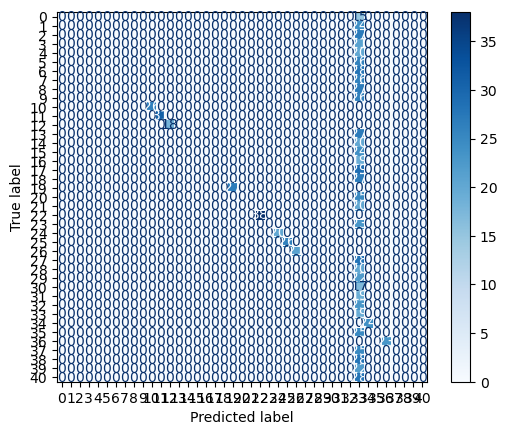


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        28
           7       0.00      0.00      0.00        26
           8       0.00      0.00      0.00        27
           9       0.00      0.00      0.00        26
          10       1.00      1.00      1.00        26
          11       1.00      1.00      1.00        31
          12       1.00      1.00      1.00        18
          13       0.00      0.00      0.00        27
          14       0.00      0.00      0.00        20
          15       0.00      0.00      0.00        24
          16       0.00      0.00      0.00     

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Check if 'Blood Pressure' column exists
if 'Blood Pressure' in df.columns:
    # Split the "Blood Pressure" column
    df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True)

    # Convert new columns to numeric
    df['Systolic_BP'] = pd.to_numeric(df['Systolic_BP'], errors='coerce')
    df['Diastolic_BP'] = pd.to_numeric(df['Diastolic_BP'], errors='coerce')

    # Drop the original "Blood Pressure" column
    df.drop('Blood Pressure', axis=1, inplace=True)

    # Fill any NaN values if necessary, e.g., with mean or median of the column
    df['Systolic_BP'].fillna(df['Systolic_BP'].mean(), inplace=True)
    df['Diastolic_BP'].fillna(df['Diastolic_BP'].mean(), inplace=True)

# Convert categorical columns to numeric using LabelEncoder
labelencoder = LabelEncoder()
df['Sex'] = labelencoder.fit_transform(df['Sex'])
df['Diet'] = labelencoder.fit_transform(df['Diet'])
df['prognosis'] = labelencoder.fit_transform(df['prognosis'])

# Check the data types to ensure all are numeric
print("Data types of the DataFrame columns:")
print(df.dtypes)

# Separate features and target variable
X = df.drop('prognosis', axis=1)
y = df['prognosis']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training, validation, and testing sets (60% training, 20% validation, 20% testing)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Feature Selection using SelectKBest
kbest = SelectKBest(score_func=f_classif, k=20)
X_train_selected = kbest.fit_transform(X_train, y_train)
X_val_selected = kbest.transform(X_val)
X_test_selected = kbest.transform(X_test)

# Get the names of the selected features
selected_feature_names = X.columns[kbest.get_support()]

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'SVM': SVC(probability=True)
}

# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10, 100]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'AdaBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'SVM': {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1]}
}

# Function to perform model evaluation
def evaluate_model(model, X_val, y_val, X_test, y_test):
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='macro'),
        'recall': recall_score(y_test, y_test_pred, average='macro'),
        'f1': f1_score(y_test, y_test_pred, average='macro'),
    }
    
    if hasattr(model, "predict_proba"):
        y_test_prob = model.predict_proba(X_test)
        metrics['roc_auc'] = roc_auc_score(y_test, y_test_prob, multi_class="ovr")
    
    return metrics

# Evaluate and tune each model
best_models = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_selected, y_train)
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    
    metrics = evaluate_model(best_model, X_val_selected, y_val, X_test_selected, y_test)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Validation Accuracy: {metrics['accuracy']:.2f}")
    print(f"Validation Precision: {metrics['precision']:.2f}")
    print(f"Validation Recall: {metrics['recall']:.2f}")
    print(f"Validation F1-score: {metrics['f1']:.2f}")
    if 'roc_auc' in metrics:
        print(f"Validation ROC-AUC: {metrics['roc_auc']:.2f}")

# Select the best model based on validation performance
best_model_name = max(best_models, key=lambda k: evaluate_model(best_models[k], X_val_selected, y_val, X_test_selected, y_test)['f1'])
best_model = best_models[best_model_name]

# Final evaluation on the test set
test_metrics = evaluate_model(best_model, X_val_selected, y_val, X_test_selected, y_test)
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}")
print(f"Test Precision: {test_metrics['precision']:.2f}")
print(f"Test Recall: {test_metrics['recall']:.2f}")
print(f"Test F1-score: {test_metrics['f1']:.2f}")
if 'roc_auc' in test_metrics:
    print(f"Test ROC-AUC: {test_metrics['roc_auc']:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, best_model.predict(X_test_selected))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, best_model.predict(X_test_selected)))
